#### Imports

In [351]:
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import json

## Global Constants

In [1]:
DATA_FILENAME = "data.json"

## Helper Functions

In [1338]:
def extract_relevant_data(full_zillow_data):
    """
    Argument: `full_zillow_data` is a JSON dictionary from the Zillow data of a sold house.
    """
    house_details = full_zillow_data["data"]["property"]
    relevant_data = {}
    relevant_data["id"] = int(house_details["zpid"])
    relevant_data["price"] = float(house_details["lastSoldPrice"])
    relevant_data["address"] = house_details["abbreviatedAddress"]
    relevant_data["location"] = house_details["formattedChip"]["location"][1]["fullValue"]
    relevant_data["beds"] = float(house_details["bedrooms"])
    relevant_data["baths"] = float(house_details["bathrooms"])
    relevant_data["acres"] = float(house_details["lotAreaValue"])
    if house_details["lotAreaUnits"] == "Square Feet":
        # Convert sqft to acres if needed
        relevant_data["acres"] /= 43560.  
    relevant_data["sqft"] = int(house_details["livingAreaValue"])
    relevant_data["year"] = int(house_details["yearBuilt"])
    relevant_data["lat"] = float(house_details['latitude'])
    relevant_data["lon"] = float(house_details['longitude'])
    relevant_data["realtor"] = house_details["brokerageName"]
    relevant_data["date_sold"] = int(house_details["dateSold"] / 1000)
    
    return relevant_data

def add_entry(json_string, ids):
    """
    Argument: `json_string` should be a non-pretty-printed raw JSON string copied from the
              Network > Response section of the web-browser's inspection window. It could be
              named 'async-create-page-state' or '?extensions=%7B...'.
    """
    full_house_data = json.loads(json_string, strict=False)  # crashes when strict=True (default)
    relevant_data = extract_relevant_data(full_house_data)

    # If the id is a duplicate, don't write it to the file
    if relevant_data["id"] in ids:
        print("id %d is a duplicate" % (relevant_data["id"]))
        return
    f = open(DATA_FILENAME, 'a')
    f.write(json.dumps(relevant_data) + "\n")
    f.close()

def load_present_ids():
    ids = set()
    f = open(DATA_FILENAME, 'r')
    for line in f:
        house_data = json.loads(line)
        ids.add(house_data["id"])
    f.close()
    return ids

def choose_city(location):
    """
    Choose which city this house is close to (Syracuse, Cortland, or Rochester)
    """
    city_name, _ = location.split(',')
    if city_name in ["Cortland", "Homer", "Tully"]:
        return "Cortland"
    elif city_name in ["Syracuse", "Liverpool", "Jamesville", "Dewitt", "Manlius", "Fayetteville", "Minoa", "East Syracuse",\
                 "North Syracuse", "Clay", "Cicero", "Brewerton", "Camillus", "Baldwinsville", "Warners", "Solvay"]:
        return "Syracuse"
    else:
        raise ValueError("Unknown city %s" % location)

# Add a New Entry Here

In [1573]:
ids = load_present_ids()
# Replace the contents of raw_json.txt
f = open("raw_json.txt", 'r', encoding="utf8")
raw_json = f.read()
f.close()

# Uncomment this code to the relevant json
#js = json.loads(raw_json)["data"]["property"]
#for key in js:
#    if not "Photo" in key and not "View" in key and not "Map" in key and not "Json" in key and not "nearby" in key and not "Valuation" in key:
#        print(key, js[key])

add_entry(raw_json, ids)

## Inspect the Data

In [1574]:
f = open(DATA_FILENAME, 'r')
all_data = {}
for line in f:
    house_data = json.loads(line)
    for key in house_data:
        if key != "date_sold":
            value = house_data[key]
        else:
            value = datetime.datetime.fromtimestamp(house_data[key])
        try:
            all_data[key].append(house_data[key])
        except KeyError:
            all_data[key] = [house_data[key]]
df = pd.DataFrame.from_dict(all_data)
print("You have data for %d houses" % (len(df)))
print("First 10")
display(df.head(10))
print("Most recent 10")
display(df.tail(10))

You have data for 1256 houses
First 10


,id,price,address,location,beds,baths,sqft,year,lat,lon,realtor,acres,date_sold
0,31765002,280000.0,4202 Henneberry Rd,"Manlius, NY 13104",3.0,2.0,1616,1977,42.975567,-76.002500,Howard Hanna Real Estate,1.2400,1694131200
1,31728477,201000.0,4515 Apulia Rd,"Jamesville, NY 13078",4.0,3.0,2100,1971,42.990322,-76.072260,Bell Home Team,0.5700,1692835200
2,61998985,400000.0,8195 Trellis Brook Ln,"Liverpool, NY 13090",4.0,3.0,2552,2003,43.169643,-76.210380,NextHome CNY Realty,0.2290,1662595200
3,60045157,330900.0,3629 Redhead Ter,"Liverpool, NY 13090",3.0,4.0,1704,2001,43.179996,-76.248474,"Your Home CNY Realty, LLC",0.2092,1656028800
4,31709619,225000.0,4211 Mill Run Rd,"Liverpool, NY 13090",3.0,2.0,1568,1976,43.160206,-76.222730,Hunt Real Estate ERA,0.1800,1696377600
5,31709342,302000.0,8183 Capricorn Dr,"Liverpool, NY 13090",3.0,3.0,1540,1987,43.166700,-76.237040,Syracuse Realty Group,0.2095,1695945600
6,31709639,255000.0,8068 Turtle Cove Rd,"Liverpool, NY 13090",4.0,2.0,1828,1977,43.160100,-76.224560,Century 21 Leah's Signature,0.2545,1695859200
7,31708059,263000.0,4080 Sweet Gum Ln,"Liverpool, NY 13090",3.0,2.0,1506,1984,43.181450,-76.231735,Howard Hanna Real Estate,0.1829,1695772800
8,31710390,360000.0,8211 Penelope Ln,"Liverpool, NY 13090",4.0,3.0,2392,1992,43.166930,-76.215225,"Coldwell Banker Prime Prop,Inc",0.2905,1695081600
9,31712938,210000.0,8009 Princess Path,"Liverpool, NY 13090",3.0,3.0,1682,1968,43.158070,-76.221664,"Coldwell Banker Prime Prop,Inc",0.2009,1695081600


Most recent 10


,id,price,address,location,beds,baths,sqft,year,lat,lon,realtor,acres,date_sold
1246,31754511,370000.0,8223 Penstock Way,"Manlius, NY 13104",4.0,3.0,2624,1984,43.001850,-75.958930,Hunt Real Estate ERA,0.46,1658275200
1247,31754560,253500.0,8230 Verbeck Dr,"Manlius, NY 13104",3.0,3.0,1846,1984,42.998413,-75.960320,Hunt Real Estate ERA,0.46,1607472000
1248,31754562,346000.0,8234 Verbeck Dr,"Manlius, NY 13104",4.0,3.0,2296,1984,42.998768,-75.960884,Howard Hanna Real Estate,0.45,1656288000
1249,31754567,290000.0,8235 Verbeck Dr,"Manlius, NY 13104",3.0,3.0,1854,1985,42.999830,-75.962450,Kirnan Real Estate,0.67,1622073600
1250,31754570,305000.0,8229 Verbeck Dr,"Manlius, NY 13104",3.0,3.0,2001,1985,42.998417,-75.961845,Howard Hanna Real Estate,0.50,1630108800
1251,31754573,432500.0,8223 Verbeck Dr,"Manlius, NY 13104",4.0,3.0,3581,1982,42.997852,-75.960950,Howard Hanna Real Estate,0.44,1682380800
1252,31754588,300000.0,8143 Verbeck Dr,"Manlius, NY 13104",3.0,3.0,1968,1986,42.997276,-75.961006,"Coldwell Banker Prime Prop,Inc",0.37,1671753600
1253,31754927,385000.0,8257 Sugarland Dr,"Manlius, NY 13104",4.0,3.0,2022,1982,43.008450,-75.954590,Berkshire Hathaway CNY Realty,0.81,1659484800
1254,31754930,360000.0,8240 Sugarland Dr,"Manlius, NY 13104",3.0,3.0,2032,1990,43.007320,-75.955990,Hunt Real Estate ERA,0.50,1623974400
1255,31754935,460000.0,8243 Drinkwater Ln,"Manlius, NY 13104",4.0,3.0,2502,1986,43.006490,-75.955850,Hunt Real Estate ERA,0.48,1695859200


## Add Calculated Columns

In [1575]:
# Calculate the price per square foot
df[["$ per sqft"]] = df["price"] / df["sqft"]
# Categorize each house by which major city it belongs to
df[["city"]] = [choose_city(location) for location in df["location"]]
syr_df = df[df['city'] == "Syracuse"]
cort_df = df[df['city'] == "Cortland"]
print("There are %d houses in the Syracuse area" % len(syr_df))
print("There are %d houses in Cortland area" % len(cort_df))

There are 1131 houses in the Syracuse area
There are 125 houses in Cortland area


# Analyze the Data

### Basic plot of price per square foot vs date sold

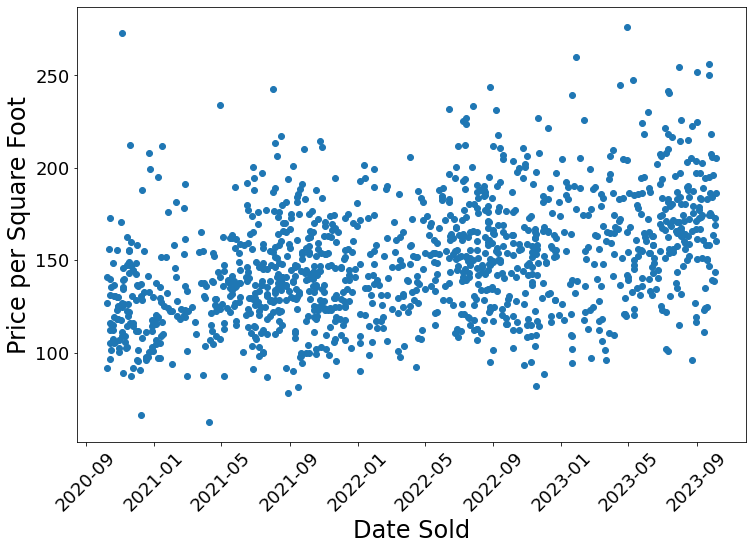

In [1576]:
prices = df.loc[:,"price"]
sqfts = df.loc[:,"sqft"]
dates = [datetime.datetime.fromtimestamp(x) for x in df.loc[:,"date_sold"]]
price_per_sqfts = prices / sqfts

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(12)
ax.plot(dates, price_per_sqfts, 'o')
ax.format_xdata = mdates.DateFormatter('%D:%M:%Y')
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=18)
ax.set_xlabel("Date Sold", fontsize=24)
ax.set_ylabel("Price per Square Foot", fontsize=24)
plt.show()

### Basic Scatterplot Separated by City

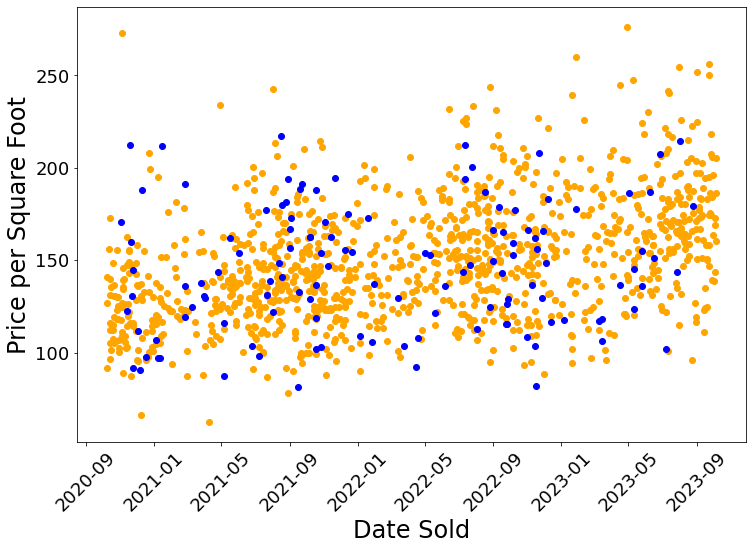

In [1577]:
syr_dates = [datetime.datetime.fromtimestamp(x) for x in syr_df.loc[:,"date_sold"]]
cort_dates = [datetime.datetime.fromtimestamp(x) for x in cort_df.loc[:,"date_sold"]]

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(12)
ax.scatter(syr_dates, syr_df['$ per sqft'], color='orange')
ax.scatter(cort_dates, cort_df['$ per sqft'], color='blue')
ax.format_xdata = mdates.DateFormatter('%D:%M:%Y')
plt.xticks(rotation=45, fontsize=18)
plt.yticks(fontsize=18)
ax.set_xlabel("Date Sold", fontsize=24)
ax.set_ylabel("Price per Square Foot", fontsize=24)
plt.show()